In [1]:
import numpy as np
import pandas as pd

def g(x1, x2):    
    return(3*(1-x1)**2 * np.exp(-(x1**2) - (x2+1)**2)
           - 10*(x1/5 - x1**3 - x2**5) * np.exp(-x1**2 - x2**2)
           - 1/3 * np.exp(-(x1+1)**2 - x2**2))
    
def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = g(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_g/virtual_samples_DotProduct.xlsx")

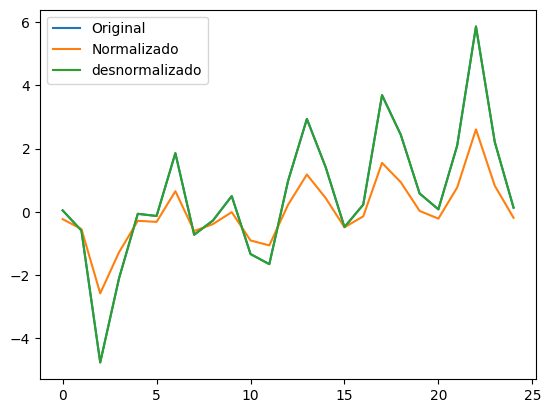

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:18:25.817359: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:18:25.830598: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:18:25.855532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753136305.902589 1085979 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753136305.927053 1085979 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753136306.003025 1085979 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36], [48], [60]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/st

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_4,0.685892,0.508597,0.617843,-0.018664,0.666797,3.286012,1.366954,0.710472,0.935039,0.816576,0.572278,0.829436,34.810540,71.775124
model_1_5_3,0.685762,0.507945,0.617819,-0.012967,0.667071,3.290377,1.367040,0.706499,0.935179,0.816744,0.572102,0.829607,34.809718,71.774302
model_1_5_1,0.685506,0.506620,0.618139,0.000390,0.667615,3.299235,1.365894,0.697183,0.936488,0.817077,0.571753,0.829945,34.808087,71.772671
model_1_5_2,0.685441,0.506467,0.617666,-0.000666,0.667753,3.300256,1.367586,0.697920,0.935282,0.817162,0.571664,0.830031,34.807672,71.772256
model_1_5_0,0.684766,0.503649,0.617835,0.024719,0.669185,3.319104,1.366980,0.680215,0.936868,0.818038,0.570746,0.830921,34.803388,71.767972


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.685897,0.508575,0.618254,0.623506,0.666786,3.286161,1.365482,1.043827,0.936206,0.816570,0.572285,0.829430,34.810572,71.775155
model_1_6_2,0.685895,0.508554,0.619063,0.620655,0.666790,3.286303,1.362591,1.051734,0.939280,0.816572,0.572282,0.829432,34.810562,71.775145
model_1_6_1,0.685895,0.508548,0.618655,0.622049,0.666790,3.286343,1.364049,1.047869,0.937736,0.816572,0.572282,0.829433,34.810559,71.775143
model_1_6_3,0.685880,0.508517,0.619445,0.619206,0.666822,3.286550,1.361224,1.055750,0.940770,0.816592,0.572262,0.829452,34.810465,71.775048
model_1_6_5,0.685072,0.506329,0.621414,0.605824,0.668537,3.301182,1.354182,1.092851,0.955065,0.817641,0.571161,0.830518,34.805326,71.769909
model_1_6_6,0.685021,0.506327,0.621748,0.604515,0.668644,3.301193,1.352984,1.096481,0.957066,0.817707,0.571093,0.830585,34.805006,71.769589
model_1_6_4,0.685108,0.506289,0.621043,0.607146,0.668459,3.301447,1.355506,1.089187,0.953008,0.817594,0.571211,0.830470,34.805560,71.770144
model_1_6_7,0.683001,0.502276,0.623161,0.586086,0.672933,3.328285,1.347933,1.147575,0.978811,0.820325,0.568342,0.833244,34.792220,71.756803


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.686849,0.521488,0.634370,0.611860,0.664764,3.199810,1.307836,0.778492,1.015526,0.815330,0.573582,0.828171,34.816647,71.781231
model_1_7_8,0.686687,0.520340,0.634102,0.614455,0.665108,3.207488,1.308797,0.773288,1.014843,0.815541,0.573361,0.828385,34.815613,71.780196
model_1_7_7,0.686163,0.517498,0.633454,0.620916,0.666221,3.226490,1.311112,0.760329,1.013572,0.816224,0.572647,0.829078,34.812268,71.776851
model_1_7_6,0.685691,0.515146,0.632594,0.625459,0.667222,3.242223,1.314191,0.751217,1.012048,0.816836,0.572005,0.829701,34.809265,71.773849
model_1_7_5,0.685266,0.513499,0.632090,0.628873,0.668124,3.253233,1.315992,0.744370,1.011836,0.817388,0.571427,0.830261,34.806564,71.771148
model_1_7_3,0.684453,0.510602,0.631061,0.634433,0.669850,3.272605,1.319674,0.733218,1.010997,0.818444,0.570319,0.831333,34.801403,71.765987
model_1_7_4,0.684482,0.510457,0.630887,0.634360,0.669788,3.273576,1.320295,0.733365,1.010195,0.818406,0.570359,0.831295,34.801587,71.766170
model_1_7_2,0.684259,0.509906,0.630757,0.635629,0.670263,3.277262,1.320761,0.730819,1.010606,0.818696,0.570054,0.831590,34.800170,71.764753
model_1_7_1,0.682756,0.505151,0.628626,0.643504,0.673452,3.309054,1.328383,0.715024,1.008091,0.820641,0.568009,0.833566,34.790676,71.755260
model_1_7_0,0.682532,0.504548,0.628350,0.644499,0.673929,3.313088,1.329369,0.713029,1.007897,0.820932,0.567703,0.833861,34.789261,71.753845


DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.687168,0.538665,0.657089,0.389242,0.664087,3.084951,1.226574,0.579409,1.051433,0.814915,0.574016,0.827749,34.818685,71.783268
model_1_8_8,0.687216,0.538348,0.656743,0.391306,0.663985,3.087069,1.227810,0.577450,1.050775,0.814853,0.574082,0.827686,34.818992,71.783576
model_1_8_7,0.687495,0.536195,0.654183,0.405554,0.663394,3.101468,1.236966,0.563934,1.046350,0.814490,0.574461,0.827317,34.820773,71.785357
model_1_8_6,0.687532,0.535758,0.653746,0.408071,0.663315,3.104388,1.238530,0.561546,1.045489,0.814442,0.574511,0.827268,34.821010,71.785593
model_1_8_5,0.687556,0.535647,0.653444,0.409393,0.663263,3.105133,1.239610,0.560292,1.045164,0.814410,0.574545,0.827236,34.821167,71.785751
model_1_8_4,0.687589,0.535265,0.653032,0.411670,0.663194,3.107684,1.241083,0.558132,1.044383,0.814367,0.574589,0.827193,34.821375,71.785958
model_1_8_3,0.687619,0.534839,0.652570,0.414249,0.663130,3.110536,1.242736,0.555685,1.043490,0.814328,0.574630,0.827153,34.821569,71.786153
model_1_8_2,0.687688,0.533980,0.651416,0.419971,0.662984,3.116275,1.246864,0.550256,1.041639,0.814238,0.574724,0.827062,34.822010,71.786593
model_1_8_1,0.687777,0.530243,0.646559,0.442833,0.662794,3.141266,1.264238,0.528568,1.033739,0.814122,0.574846,0.826943,34.822583,71.787166
model_1_8_0,0.686962,0.521903,0.635367,0.487704,0.664523,3.197034,1.304272,0.486001,1.016690,0.815183,0.573736,0.828021,34.817371,71.781954


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.683947,0.552768,0.670412,0.490938,0.670925,2.990642,1.178917,0.614498,1.157181,0.819100,0.569630,0.832000,34.798196,71.762780
model_1_9_8,0.684081,0.552481,0.670173,0.493635,0.670640,2.992564,1.179773,0.611243,1.153813,0.818926,0.569812,0.831824,34.799045,71.763629
model_1_9_7,0.684219,0.552156,0.669915,0.496468,0.670347,2.994735,1.180694,0.607823,1.150388,0.818747,0.570000,0.831642,34.799919,71.764502
model_1_9_6,0.684362,0.551773,0.669626,0.499505,0.670044,2.997293,1.181730,0.604156,1.146928,0.818562,0.570195,0.831454,34.800822,71.765406
model_1_9_5,0.685525,0.548785,0.666891,0.527167,0.667576,3.017277,1.191513,0.570765,1.111762,0.817053,0.571778,0.829921,34.808205,71.772789
model_1_9_4,0.685863,0.547573,0.665854,0.536577,0.666858,3.025384,1.195220,0.559407,1.100269,0.816614,0.572238,0.829475,34.810355,71.774939
model_1_9_3,0.685971,0.547133,0.665483,0.539830,0.666627,3.028326,1.196546,0.555480,1.096348,0.816472,0.572387,0.829331,34.811049,71.775633
model_1_9_2,0.686528,0.544900,0.663134,0.559785,0.665446,3.043252,1.204951,0.531391,1.068483,0.815749,0.573144,0.828596,34.814597,71.779180
model_1_9_1,0.686607,0.544451,0.662720,0.563056,0.665277,3.046260,1.206432,0.527443,1.064226,0.815645,0.573253,0.828491,34.815103,71.779687
model_1_9_0,0.686822,0.543016,0.661398,0.573135,0.664821,3.055857,1.211159,0.515276,1.060882,0.815365,0.573546,0.828206,34.816476,71.781060


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  21
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.684298,0.553063,0.672389,0.482177,0.670179,2.988672,1.171847,0.728908,1.154076,0.818644,0.570109,0.831537,34.800422,71.765006
model_1_10_6,0.684564,0.548373,0.674304,0.459917,0.669615,3.020030,1.164996,0.760241,1.143382,0.818300,0.570470,0.831187,34.802106,71.766690
model_1_10_9,0.684312,0.548291,0.675023,0.453866,0.670150,3.020580,1.162422,0.768760,1.142108,0.818627,0.570127,0.831519,34.800508,71.765092
model_1_10_3,0.684791,0.548290,0.673288,0.467162,0.669134,3.020585,1.168630,0.750044,1.145060,0.818006,0.570779,0.830889,34.803542,71.768126
model_1_10_5,0.684608,0.548229,0.674101,0.461035,0.669522,3.020995,1.165722,0.758668,1.143535,0.818243,0.570530,0.831130,34.802383,71.766966
model_1_10_7,0.684532,0.548206,0.674356,0.458997,0.669682,3.021149,1.164811,0.761537,1.143062,0.818341,0.570427,0.831229,34.801904,71.766488
model_1_10_8,0.684363,0.548150,0.674831,0.454973,0.670041,3.021520,1.163110,0.767202,1.142198,0.818561,0.570197,0.831452,34.800831,71.765415
model_1_10_2,0.684822,0.548145,0.673061,0.468306,0.669067,3.021558,1.169440,0.748433,1.145271,0.817965,0.570822,0.830847,34.803742,71.768326
model_1_10_4,0.684650,0.548085,0.673895,0.462153,0.669433,3.021955,1.166458,0.757095,1.143694,0.818189,0.570587,0.831075,34.802648,71.767231
model_1_10_1,0.684851,0.548010,0.672847,0.469425,0.669006,3.022457,1.170208,0.746858,1.145483,0.817928,0.570861,0.830809,34.803924,71.768508


DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.684393,0.547781,0.673733,0.726075,0.669977,3.023993,1.167037,0.452192,1.143428,0.818521,0.570238,0.831412,34.801024,71.765607
model_1_11_1,0.684492,0.546547,0.671549,0.721506,0.669767,3.032245,1.174849,0.459734,1.145128,0.818393,0.570372,0.831282,34.801650,71.766234
model_1_11_2,0.684457,0.545254,0.666881,0.706928,0.669843,3.040886,1.191548,0.483798,1.156814,0.818439,0.570324,0.831329,34.801425,71.766008
model_1_11_3,0.684432,0.545122,0.666315,0.705095,0.669895,3.041770,1.193571,0.486824,1.158231,0.818471,0.570290,0.831361,34.801269,71.765852
model_1_11_4,0.684417,0.544725,0.665609,0.703625,0.669927,3.044423,1.196096,0.489251,1.159518,0.818491,0.570270,0.831381,34.801172,71.765756
model_1_11_5,0.683473,0.542485,0.656800,0.675491,0.671931,3.059406,1.227606,0.535694,1.181075,0.819714,0.568984,0.832624,34.795199,71.759783
model_1_11_6,0.683408,0.542127,0.656158,0.674116,0.672070,3.061802,1.229901,0.537964,1.182169,0.819799,0.568896,0.832710,34.794787,71.759370
model_1_11_7,0.683328,0.541936,0.655602,0.672516,0.672239,3.063073,1.231893,0.540606,1.183341,0.819902,0.568787,0.832814,34.794284,71.758867
model_1_11_8,0.682988,0.541164,0.653405,0.666228,0.672961,3.068236,1.239751,0.550985,1.187997,0.820342,0.568324,0.833262,34.792135,71.756718
model_1_11_9,0.682891,0.541076,0.652912,0.664534,0.673167,3.068824,1.241513,0.553782,1.189169,0.820467,0.568192,0.833389,34.791524,71.756108


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.684637,0.514620,0.646680,0.768684,0.669460,3.245741,1.263804,1.201863,1.045021,0.818205,0.570570,0.831091,34.802568,71.767152
model_1_12_1,0.684490,0.512987,0.646454,0.764197,0.669773,3.256661,1.264613,1.225179,1.026817,0.818396,0.570369,0.831285,34.801633,71.766217
model_1_12_2,0.683497,0.508159,0.645199,0.750890,0.671879,3.288942,1.269102,1.294318,0.979392,0.819682,0.569018,0.832592,34.795353,71.759937
model_1_12_3,0.683351,0.507664,0.645032,0.749467,0.672189,3.292253,1.269701,1.301714,0.977054,0.819871,0.568819,0.832784,34.794431,71.759014
model_1_12_4,0.682328,0.504762,0.643867,0.741063,0.674361,3.311657,1.273869,1.345377,0.967762,0.821195,0.567426,0.834128,34.787979,71.752562


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  34
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_8,0.684344,0.539554,0.669724,0.478039,0.670082,3.079002,1.181378,0.633652,1.029056,0.818585,0.570171,0.831477,34.800711,71.765295
model_1_14_7,0.685217,0.532904,0.665202,0.509650,0.668228,3.123474,1.197553,0.595277,1.030458,0.817452,0.571359,0.830326,34.806251,71.770834
model_1_14_6,0.685259,0.532273,0.664776,0.512333,0.668140,3.127695,1.199075,0.592020,1.030530,0.817398,0.571416,0.830272,34.806515,71.771098
model_1_14_5,0.685531,0.524314,0.659223,0.545151,0.667562,3.180914,1.218940,0.552180,1.031632,0.817045,0.571787,0.829913,34.808245,71.772829
model_1_14_4,0.685505,0.522850,0.658139,0.550975,0.667616,3.190704,1.222817,0.545110,1.031753,0.817078,0.571752,0.829946,34.808083,71.772667
model_1_14_3,0.685484,0.521434,0.657094,0.556637,0.667662,3.200173,1.226554,0.538236,1.032023,0.817106,0.571723,0.829974,34.807948,71.772531
model_1_14_2,0.685375,0.519043,0.655337,0.565572,0.667894,3.216160,1.232840,0.527389,1.032206,0.817248,0.571574,0.830118,34.807253,71.771837
model_1_14_1,0.684933,0.512630,0.650473,0.589206,0.668831,3.259048,1.250237,0.498697,1.033080,0.817821,0.570973,0.830701,34.804446,71.769030
model_1_14_0,0.684366,0.508069,0.646892,0.604884,0.670036,3.289548,1.263048,0.479665,1.033408,0.818557,0.570200,0.831449,34.800849,71.765432


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4], regularizer=0.02, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_0_0,0.65922,0.521394,0.640958,0.067864,0.723416,3.200438,1.284271,1.263031,1.129678,0.850539,0.535959,0.863934,34.647541,71.612124


DataFrame salvo em ./content/results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_1_2,0.665939,0.558027,0.578750,-0.190105,0.709153,2.955476,1.506785,1.220226,1.864214,0.842112,0.545108,0.855374,34.687369,71.651953
model_4_1_3,0.684106,0.552052,0.587501,-0.116557,0.670587,2.995431,1.475484,1.144817,1.763188,0.818894,0.569847,0.831791,34.799203,71.763787
model_4_1_4,0.703521,0.538640,0.593728,-0.014054,0.629373,3.085114,1.453212,1.039719,1.619020,0.793330,0.596284,0.805824,34.926063,71.890646
model_4_1_1,0.686688,0.531355,0.620553,0.246718,0.665106,3.133830,1.357262,0.772347,1.374702,0.815540,0.573362,0.828384,34.815617,71.780201
model_4_1_0,0.685023,0.519450,0.639866,0.382397,0.668640,3.213438,1.288180,0.633234,1.135583,0.817704,0.571095,0.830582,34.805018,71.769602
model_4_1_5,0.720467,0.508821,0.579205,0.032885,0.593399,3.284519,1.505161,0.991592,1.420393,0.770324,0.619360,0.782456,35.043777,72.008361
model_4_1_6,0.718362,0.508668,0.570809,-0.043853,0.597868,3.285542,1.535193,1.070272,1.464720,0.773220,0.616492,0.785397,35.028769,71.993353
model_4_1_7,0.716057,0.507166,0.569133,-0.091579,0.602760,3.295583,1.541186,1.119205,1.511472,0.776376,0.613354,0.788604,35.012471,71.977054
model_4_1_8,0.713955,0.501994,0.564460,-0.126714,0.607224,3.330166,1.557902,1.155230,1.546376,0.779246,0.610491,0.791518,34.997716,71.962299
model_4_1_9,0.711755,0.500650,0.564597,-0.156934,0.611894,3.339158,1.557413,1.186214,1.577449,0.782237,0.607496,0.794556,34.982392,71.946976


DataFrame salvo em ./content/results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━